In [2]:
import sys
# Assuming your Jupyter notebook is in the 'scripts' directory,
# and you want to add the parent directory (root) to sys.path
sys.path.append("..") # Adds the parent directory to sys.path

# Now try importing your
from src.DataBaseManager import DBMS
import folium
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from config import LAND_COVER_PALETTE, LAND_COVER_LEGEND
import time




def sql_list_strings(list_):
    return ','.join(["'"+str(i)+"'" for i in list_])

def dissolve_and_add_to_map(gdf,m,checkpoint,color='green'):
    dissolved = gdf.dissolve(by='chipid')
    checkpoint2 = time.time()
    print(f'Dissolved Polygons: {checkpoint2-checkpoint}')
    # Add polygons to the map
    for _, row in dissolved.iterrows():
        sim_geo = folium.GeoJson(row.geometries, style_function=lambda x: {'fillColor': f'{color}', 'color': f'{color}', 'weight': 2})
        sim_geo.add_to(m)

    return m,checkpoint2

def plot_folium(gdf,checkpoint):
    # Assuming 'gdf' is your GeoDataFrame with polygons
    # Ensure the CRS of gdf is in WGS84 (EPSG:4326) for Folium compatibility
    gdf = gdf.to_crs(epsg=4326)

    # Create a Folium map object
    m = folium.Map(location=[gdf.geometries.centroid.y.mean(), gdf.geometries.centroid.x.mean()], zoom_start=12)

    gdf_dw = gdf[gdf['data_origins']=='DynamicWorld']
    external_categories = gdf['data_origins'].unique().tolist()

    m,checkpoint = dissolve_and_add_to_map(gdf_dw,m,checkpoint)

    for ec in external_categories:
        if ec == 'DynamicWorld':
            continue
        print(ec)
        gdf_ec = gdf[gdf['data_origins']==ec]

        m,checkpoint = dissolve_and_add_to_map(gdf_ec,m,checkpoint,color='blue')

    # Display the map
    return m,checkpoint

def plot_static_map(gdf):

    colormap = {LAND_COVER_LEGEND[ix]: LAND_COVER_PALETTE[ix] for ix in LAND_COVER_PALETTE.keys()}

    # Ensure the 'name' column exists and maps to the correct land cover class
    gdf = gdf.sort_values('data_origins')
    gdf['color'] = gdf['name'].map(colormap)  # Default to black if not found

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the entire GeoDataFrame at once using the 'color' column for color coding
    gdf.plot(ax=ax, color=gdf['color'], alpha=0.75)  # Adjust alpha as needed

    # Add the OSM Mapnik map as the base layer
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())

    # Adjust the plot limits to the bounds of the GeoDataFrame
    ax.set_xlim(gdf.total_bounds[[0, 2]])
    ax.set_ylim(gdf.total_bounds[[1, 3]])

    # Create legend labels based on the colormap
    legend_labels = [Patch(facecolor=color, label=class_name) for class_name, color in colormap.items()]
    ax.legend(handles=legend_labels, title='Landcover Classes')

    return fig

def plot_chip_from_db(chip_ids=None,area='Denmark',years = ['2016','2016'],sub_areaID=None,max_chips=20,chunk_idx=0):
    DB = DBMS()
    
    start = time.time()
    if not chip_ids and not sub_areaID:
        return 'Please provide chip_ids or sub_areaID'
    if not chip_ids:
        all_chip_ids = DB.read('GET_CHIPIDS',{'_AREA_':area,
                                              '_SUB_AREAID_':sub_areaID})['chipid'].tolist()
        
        chip_ids = all_chip_ids[chunk_idx*max_chips:(chunk_idx+1)*max_chips]

        print(f"Plotting {len(chip_ids)} of {len(all_chip_ids)} chips")

    
    print(chip_ids)
    
    

    results = DB.read('GET_DW_LANDCOVER',{'_CHIPIDS_':sql_list_strings(chip_ids),
                                '_AREA_':area,
                                '_START_YEAR_':years[0],
                                '_END_YEAR_':years[1],},
                                geom_query = True)
    print(results['data_origins'].unique())

    checkpoint1 = time.time()
    print(f'Got chips from database: {checkpoint1-start}')
    #return results
    dynamic_map,checkpoint2 = plot_folium(results,checkpoint1)
    checkpoint3 = time.time()
    print(f'Plotted folium: {checkpoint3-checkpoint2}')
    static_map = plot_static_map(results)

    checkpoint4 = time.time()
    print(f'Plotted static map: {round(checkpoint4-checkpoint3,2)}')
    
    return dynamic_map,static_map


#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])



#tst['geometries'] = tst['geometries'].apply(wkt.loads)

# Now, convert the DataFrame to a GeoDataFrame
#gdf = gpd.GeoDataFrame(tst, geometry='geometries')

# Set the CRS to EPSG:4326 for the GeoDataFrame
#gdf.crs = "EPSG:4326"
#plot_folium(gpd.GeoDataFrame(tst).set_geometry('geometries'))
#gdf


/Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
mapping = {'0':'Fanø',
           '1':'Rømø',
           '2':"Læsø",
           "3":"Ærø",
           "4":"Samsø",
           "5":"Bornholm",
           "6":"Møn",
           "7":"Mors",
           "8":"Langeland",           
           "9":"Als",
           "10":"Lolland", # HERFRA ER DE RET STORE, SÅ OVERVEJ AT BRUG MAX_CHIP_IDS OG CHUNK_IDX TIL AT PLOTTE LIDT AF GANGEN
           "11":"Fyn",
           "12":"Nørrejyske Ø",
           "13":"Sjælland + Falster",
           "14":"Midt-og-Sønderjylland",
           }



['13_1_8']
['DynamicWorld']
Got chips from database: 35.931230783462524
Dissolved Polygons: 0.4046010971069336
Plotted folium: 0.017346858978271484
Plotted static map: 3.09


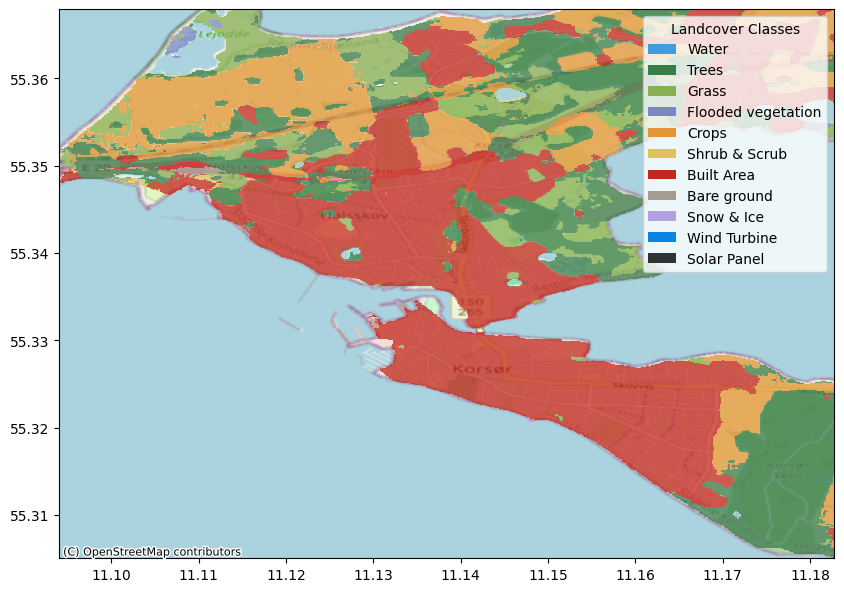

In [5]:
ids = ['13_1_8']
dynamic_map_2,static_map_2 = plot_chip_from_db(chip_ids = ids,years = ['2016','2016'])
dynamic_map_2

['13_1_8']
['DynamicWorld']
Got chips from database: 49.07974910736084
Dissolved Polygons: 0.35482096672058105
Plotted folium: 0.0137939453125
Plotted static map: 0.68


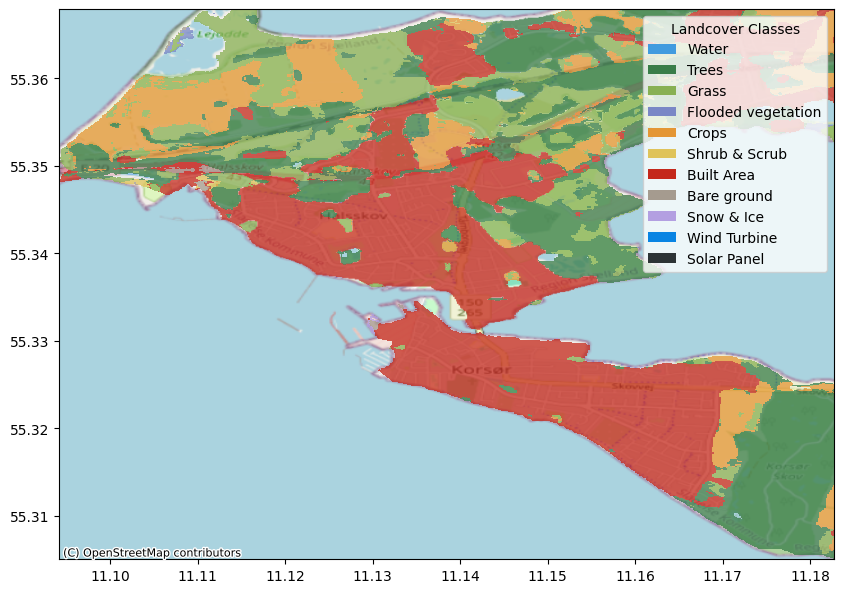

In [6]:
ids = ['13_1_8']
dynamic_map_2,static_map_2 = plot_chip_from_db(chip_ids = ids,years = ['2017','2017'])
dynamic_map_2

['14_12_19']
['DynamicWorld' 'SATLAS']
Got chips from database: 38.66067099571228
Dissolved Polygons: 1.0431439876556396
SATLAS
Dissolved Polygons: 0.012817859649658203
Plotted folium: 0.009634971618652344
Plotted static map: 2.81


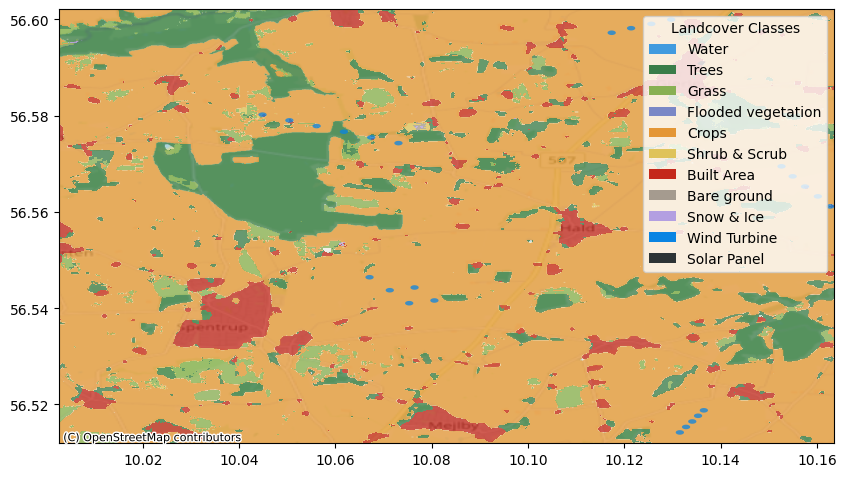

In [10]:
ids = ['14_12_19']
dynamic_map_2,static_map_2 = plot_chip_from_db(chip_ids = ids,years = ['2016','2016'])
dynamic_map_2

['14_12_19']
['SATLAS' 'DynamicWorld']
Got chips from database: 35.189825773239136
Dissolved Polygons: 3.153916120529175
SATLAS
Dissolved Polygons: 0.03596186637878418
Plotted folium: 0.016994953155517578
Plotted static map: 2.48


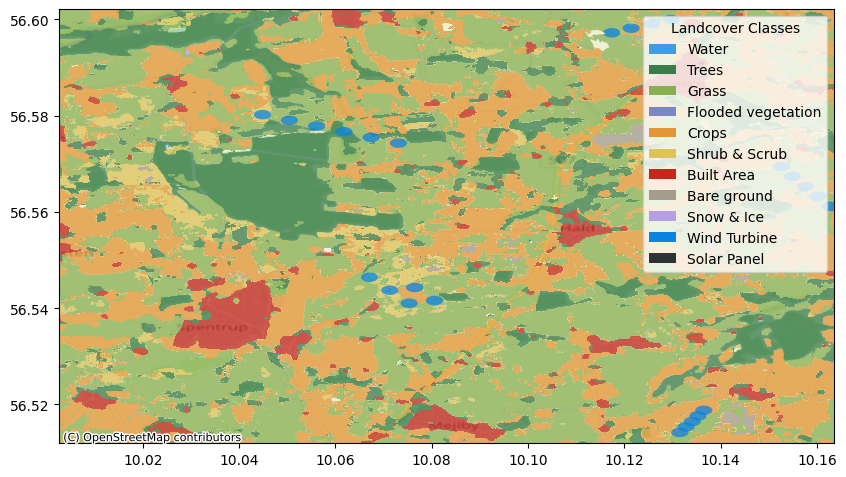

In [11]:
ids = ['14_12_19']
dynamic_map_2,static_map_2 = plot_chip_from_db(chip_ids = ids,years = ['2017','2017'])
dynamic_map_2

['14_1_10']
['SATLAS' 'DynamicWorld']
Got chips from database: 17.390766859054565
Dissolved Polygons: 1.506221055984497
SATLAS
Dissolved Polygons: 0.009799480438232422
Plotted folium: 0.00074005126953125
Plotted static map: 0.77


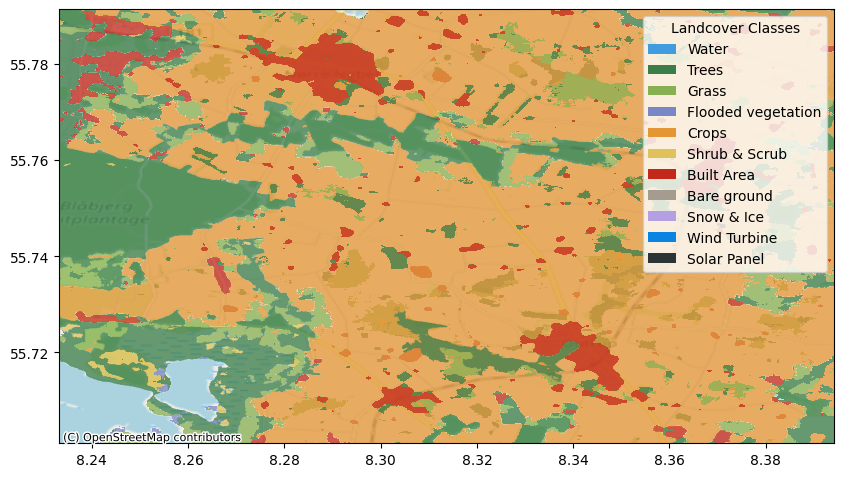

In [9]:

ids = ['14_1_10']
dynamic_map_2,static_map_2 = plot_chip_from_db(chip_ids = ids,years = ['2023','2023'])
dynamic_map_2

['14_3_2']
['DynamicWorld' 'SATLAS']
Got chips from database: 17.515269994735718
Dissolved Polygons: 0.5519442558288574
SATLAS
Dissolved Polygons: 0.018286705017089844
Plotted folium: 0.009695053100585938
Plotted static map: 0.94


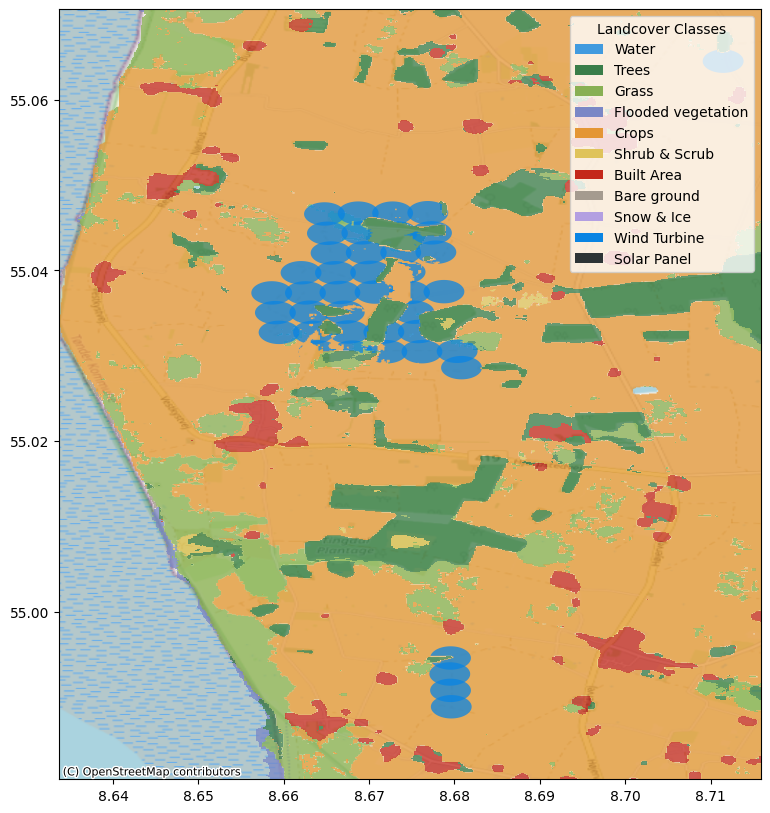

In [7]:

ids = ["14_3_2"]
dynamic_map_2,static_map_2 = plot_chip_from_db(chip_ids = ids,years = ['2021','2021'])
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='6',area='Estonia',max_chips=8,chunk_idx=61)
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='0',area='Israel',max_chips=10)
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='1',area='Israel',max_chips=20,chunk_idx=14)
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='6',area='Netherlands',max_chips=10,chunk_idx=4)
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='6',area='Netherlands',max_chips=10,chunk_idx=9)
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='6',area='Netherlands',max_chips=10,chunk_idx=9)
dynamic_map_2

In [ ]:

dynamic_map_2,static_map_2 = plot_chip_from_db(sub_areaID='2')
dynamic_map_2

In [ ]:

dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='3')
dynamic_map_3

In [ ]:

dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='4')
dynamic_map_3

In [ ]:

dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='5')
dynamic_map_3

In [ ]:

dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='6')
dynamic_map_3

In [ ]:

dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='7')
dynamic_map_3

In [ ]:

dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='8')
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='9')
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='10',max_chips=50)
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='11',max_chips=15,chunk_idx=0)
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='11',max_chips=5,chunk_idx=4)
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='11',max_chips=5,chunk_idx=5)
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='11',max_chips=5,chunk_idx=6)
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='12',max_chips=50)
dynamic_map_3

In [ ]:
dynamic_map_3,static_map_3 = plot_chip_from_db(sub_areaID='13',max_chips=50)
dynamic_map_3

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=0)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=1)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=2)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=3)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=4)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=5)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=6)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='14',max_chips=20,chunk_idx=7)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='13',max_chips=20,chunk_idx=0)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='13',max_chips=20,chunk_idx=2)   
dynamic_map

In [ ]:
#dynamic_map,static_map = plot_chip_from_db(['0_0_0','0_0_1-a','0_0_1-b'])
dynamic_map,static_map = plot_chip_from_db(sub_areaID='13',max_chips=20,chunk_idx=4)   
dynamic_map

In [ ]:
mapping = {'0':'Fanø',
           '1':'Rømø',
           '2':"Læsø",
           "3":"Ærø",
           "4":"Samsø",
           "5":"Bornholm",
           "6":"Møn",
           "7":"Mors",
           "8":"Langeland",           
           "9":"Als",
           "10":"Lolland",
           "11":"Fyn",
           "12":"Nørrejyske Ø",
           "13":"Sjælland + Falster",
           "14":"Midt-og-Sønderjylland",
           }